<a href="https://colab.research.google.com/github/shangeth/wavencoder/blob/master/examples/wavencoder_demo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo Notebook 2 
## Training Speech Commands Classifier with [wavencoder](https://pypi.org/project/wavencoder/) and PyTorch
---


Author : Shangeth Rajaa

![Twitter Follow](https://img.shields.io/twitter/follow/shangethr?style=social)

[GitHub](https://github.com/shangeth) [LinkedIn](https://www.linkedin.com/in/shangeth/)

# Installing wavencoder

In [30]:
!pip install fairseq
!pip install wavencoder==0.0.7

# install torchaudio for audio dataset
!pip install torchaudio

  Found existing installation: wavencoder 0.0.6
    Uninstalling wavencoder-0.0.6:
      Successfully uninstalled wavencoder-0.0.6


In [1]:
# import wavencoder models and trainer
from wavencoder.models import Wav2Vec, LSTM_Attn_Classifier
from wavencoder.trainer import train, test_evaluate_classifier, test_predict_classifier

# import torch modules and torchaudio for data
import torchaudio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset

import random
import IPython
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 

# Download Speech Commands Dataset with TorchAudio

In [2]:
# download dataset with torchaudio.datasets
dataset = torchaudio.datasets.SPEECHCOMMANDS('./', download=True, url= 'speech_commands_v0.02')

In [3]:
idx = random.randint(0,len(dataset))
dataset[idx]

(tensor([[3.0518e-05, 0.0000e+00, 1.5259e-04,  ..., 3.3569e-04, 3.0518e-04,
          2.7466e-04]]), 16000, 'zero', 'ffd2ba2f', 3)

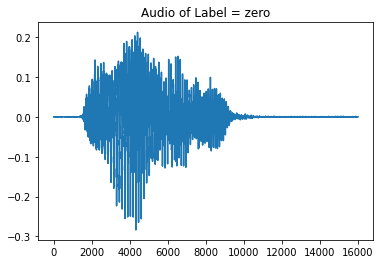

In [4]:
sample_audio = dataset[idx][0].numpy().reshape(-1)
sample_rate = dataset[idx][1]
sample_label = dataset[idx][2]

plt.title(f"Audio of Label = {sample_label}")
plt.plot(sample_audio)
plt.show()

IPython.display.Audio(data=sample_audio, rate=16000)

In [5]:
# get a dictionary of label-index

labels = []
for i in tqdm(range(len(dataset))):
    labels.append(dataset[i][2])
    labels = list(set(labels))
labels_dict = {k: v for v, k in enumerate(labels)}
labels_count_list = {k: 0 for  k in labels}
labels_dict

100%|██████████| 105829/105829 [00:13<00:00, 7741.61it/s]


{'backward': 4,
 'bed': 27,
 'bird': 34,
 'cat': 12,
 'dog': 19,
 'down': 6,
 'eight': 25,
 'five': 31,
 'follow': 7,
 'forward': 9,
 'four': 15,
 'go': 10,
 'happy': 20,
 'house': 13,
 'learn': 18,
 'left': 0,
 'marvin': 23,
 'nine': 33,
 'no': 22,
 'off': 3,
 'on': 24,
 'one': 8,
 'right': 14,
 'seven': 29,
 'sheila': 5,
 'six': 11,
 'stop': 28,
 'three': 26,
 'tree': 1,
 'two': 17,
 'up': 21,
 'visual': 16,
 'wow': 30,
 'yes': 32,
 'zero': 2}

In [6]:
class_num = len(labels)
class_num

35

100%|██████████| 105829/105829 [00:12<00:00, 8282.60it/s]


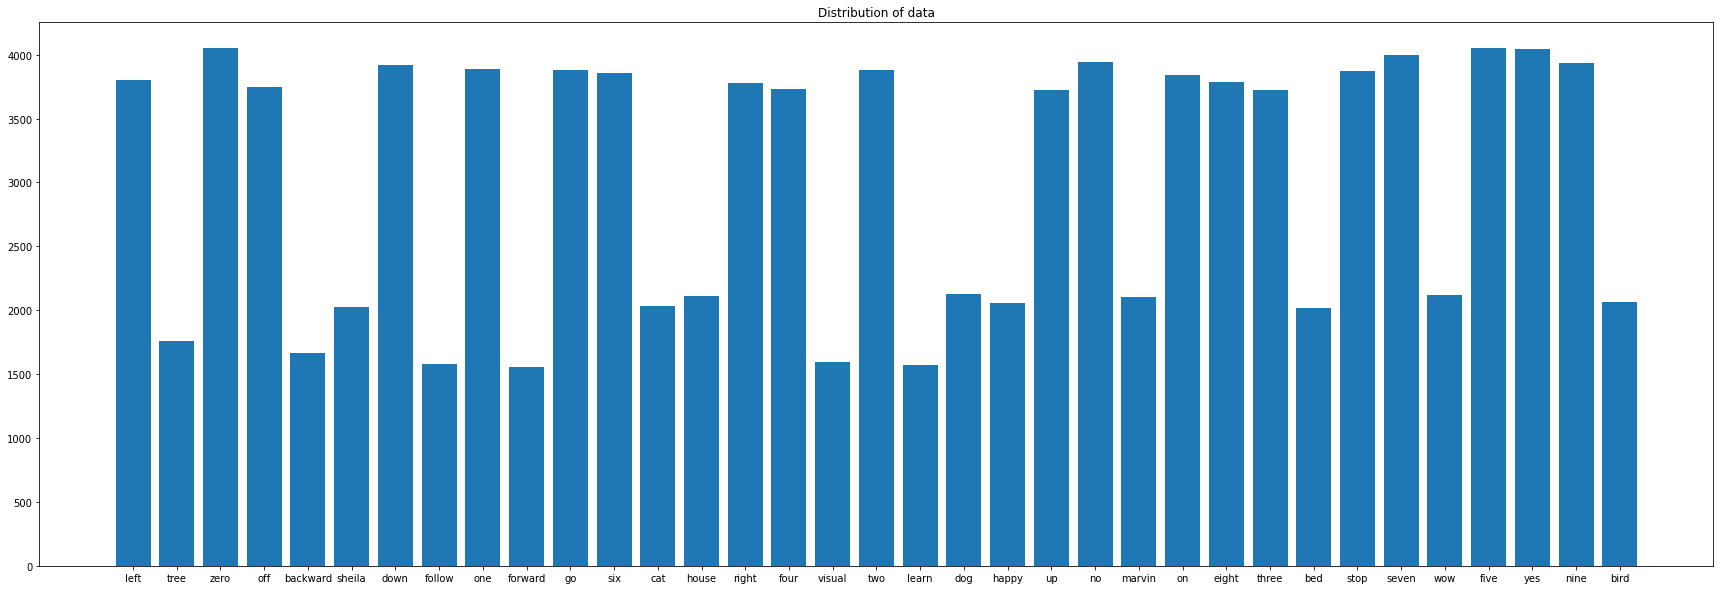

In [7]:
# visualize the count of no of wav file for each class

for i in tqdm(range(len(dataset))):
    label = dataset[i][2]
    labels_count_list[label] += 1

plt.figure(figsize=(30,10))
plt.title('Distribution of data')
plt.bar(labels_count_list.keys(), labels_count_list.values())
plt.show()

# PyTorch Custom Dataset

In [8]:
class SpeechDataset(Dataset):
    def __init__(self, dataset, label_dict, transforms=None):
        self.dataset = dataset
        self.label_dict = label_dict
        self.transforms = transforms
            
    def __len__(self):
        return len(self.dataset)    
    
    def pad_crop_wave(self, waveform, l):
        l_wave = waveform.shape[1]
        if l_wave > l:
            i=0
            waveform = waveform[:, i:i+l]
        elif l_wave < l:
            delta = l-l_wave
            if delta > l_wave:
                waveform = nn.ConstantPad1d((0, delta), 0)(waveform)
            else:
                waveform_new = torch.randn(waveform.shape[0], l)
                waveform_new[:, :l_wave] = waveform
                i=0
                waveform_new[:, l_wave:] = waveform[:, i:i+delta]
                waveform = waveform_new
        else:
            waveform = waveform
        return waveform

    def __getitem__(self,idx):
        waveform = self.dataset[idx][0]
        waveform = self.pad_crop_wave(waveform, l=16000)
        if self.transforms:
            waveform = self.transforms(waveform)
        label = self.dataset[idx][2]
        label_idx = self.label_dict[label]
        return waveform.squeeze(0), label_idx

In [9]:
audio_dataset = SpeechDataset(dataset, labels_dict)
audio_dataset[0][0].shape

torch.Size([16000])

In [10]:
train_len = int(len(audio_dataset) * 0.8)
val_len = len(audio_dataset) - train_len

train_ds, val_ds = random_split(audio_dataset, [train_len, val_len])
len(train_ds), len(val_ds)

(84663, 21166)

## Dataloader

In [11]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=256, shuffle=False)

In [12]:
batch = next(iter(valloader))
x, y = batch

x.shape, y.shape

(torch.Size([256, 16000]), torch.Size([256]))

# Wavencoder

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
model = nn.Sequential(
    Wav2Vec(pretrained=True),
    LSTM_Attn_Classifier(512, 128, class_num)
)
print(model)

Sequential(
  (0): Wav2Vec(
    (feature_extractor): ConvFeatureExtractionModel(
      (conv_layers): ModuleList(
        (0): Sequential(
          (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (1): Dropout(p=0.0, inplace=False)
          (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
          (3): ReLU()
        )
        (1): Sequential(
          (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
          (1): Dropout(p=0.0, inplace=False)
          (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
          (3): ReLU()
        )
        (2): Sequential(
          (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
          (1): Dropout(p=0.0, inplace=False)
          (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
          (3): ReLU()
        )
        (3): Sequential(
          (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
          (1): Dropout(p=0.0, inplace=False)
          (2): Fp32GroupNorm

In [15]:
print('\n# Model Parameters = ', count_parameters(model))

for param in model[0].feature_extractor.parameters():
    param.requires_grad = False

for param in model[0].feature_extractor.conv_layers[6].parameters():
    param.requires_grad = True

print('# Model Parameters after freezing = ', count_parameters(model))
x = torch.randn(1, 16000) 
y_hat = model(x) 

print(y_hat.shape)


# Model Parameters =  6112675
# Model Parameters after freezing =  596387
torch.Size([1, 35])


In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-1, step_size_up=10)
model, train_dict = train(model, trainloader, valloader, n_epochs=50, optimizer=optimizer, scheduler=scheduler)

Train:   0%|          | 0/166 [00:00<?, ?it/s]

Validation loss reduced from inf to 2.666579, saving model at trained_model.pt ...
Updating lr to [0.010090000000000009]
Epoch : 01
Train Loss = 3.0570	Train Acc = 0.15896410951181775
  Val Loss = 2.6666	  Val Acc = 0.2379588396690209



Train:  79%|███████▉  | 131/166 [02:29<00:40,  1.14s/it]

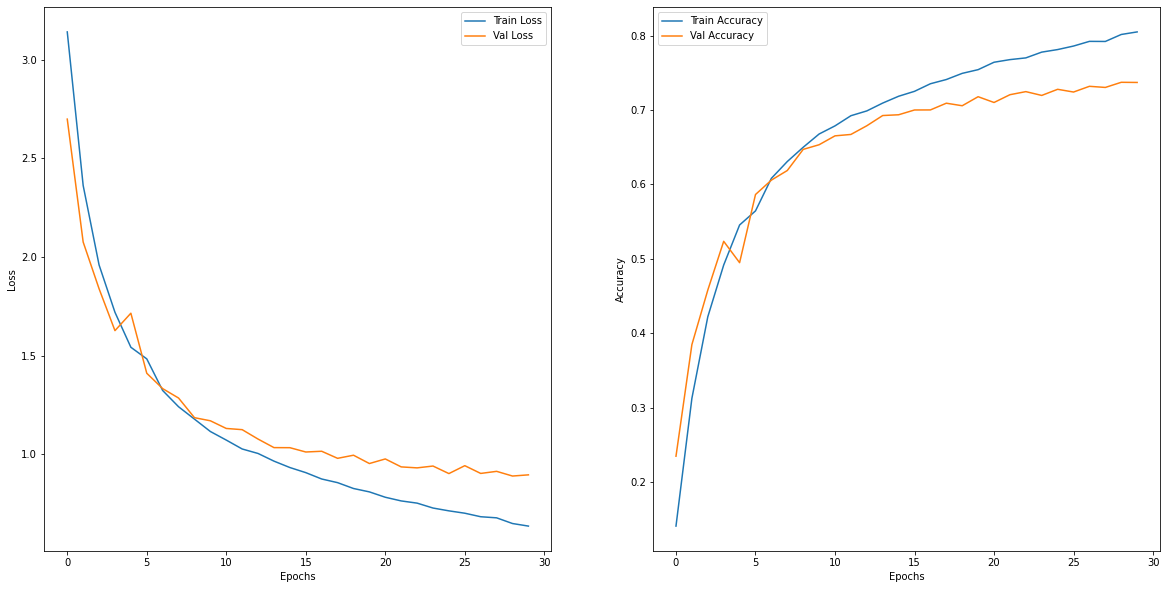

In [ ]:
train_losses = train_dict['train_losses']
train_accuracies = train_dict['train_accuracies']
val_losses = train_dict['val_losses']
val_accuracies = train_dict['val_Accuracies']

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [ ]:
test_evaluate_classifier(model, valloader)

100%|██████████| 83/83 [00:22<00:00,  3.61it/s]


{'test_acc': 0.7369423815953469, 'test_loss': 0.8959246249084013}